In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Dropout , UpSampling2D, Concatenate, MaxPooling2D, Cropping2D, concatenate, ZeroPadding2D, Lambda
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Mean
from tensorflow.keras.applications import VGG19
import time
import cv2


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Define paths
base_path = r"/content/drive/My Drive/Train"
train_low_path = os.path.join(base_path, "low")
train_high_path = os.path.join(base_path, "high")

# Print paths for verification
print(f"Train - Low Light Images: {train_low_path}")
print(f"Train - High Light Images: {train_high_path}")

# Helper function to filter image files
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff'])

# Load image paths, filtering out non-image files
low_light_images = sorted([os.path.join(train_low_path, img) for img in os.listdir(train_low_path) if is_image_file(img)])
high_light_images = sorted([os.path.join(train_high_path, img) for img in os.listdir(train_high_path) if is_image_file(img)])

Train - Low Light Images: /content/drive/My Drive/Train/low
Train - High Light Images: /content/drive/My Drive/Train/high


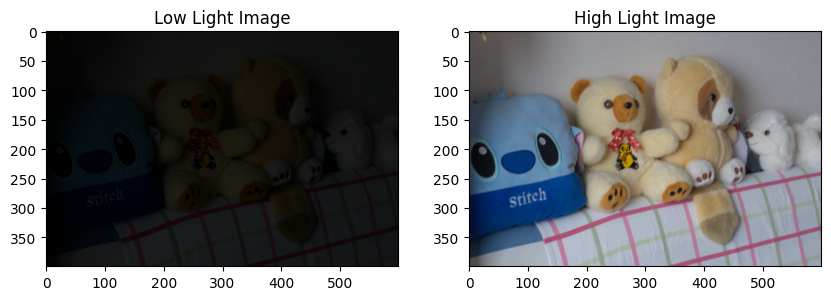

In [7]:
# Function to load images
def load_image(path):
    return img_as_float(io.imread(path))

# Load a pair of images for visualization
low_light_image = load_image(low_light_images[0])
high_light_image = load_image(high_light_images[0])

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Low Light Image')
plt.imshow(low_light_image)
plt.subplot(1, 2, 2)
plt.title('High Light Image')
plt.imshow(high_light_image)
plt.show()

In [ ]:
#Iteration 1

In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    res = Conv2D(filters, kernel_size, padding=padding)(x)
    res = BatchNormalization()(res)
    res = Activation(activation)(res)
    res = Conv2D(filters, kernel_size, padding=padding)(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])
    return x

In [ ]:
def build_denoising_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding more residual blocks
    for _ in range(5):  # Increase the depth of the network
        x = residual_block(x, 64)

    outputs = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = low_light_image.shape
model = build_denoising_model(input_shape)
model.summary()

# Define loss function and optimizer
loss_function = MeanSquaredError()

# Learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# Training parameters
epochs = 100
batch_size = 32
steps_per_epoch = 20
accumulation_steps = 4

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 400, 600, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 400, 600, 64)         256       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_3 (Activation)   (None, 400, 600, 64)         0         ['batch_normalization_3[

In [ ]:
# Prepare the data generator
def data_generator(low_light_images, high_light_images, batch_size):
    while True:
        indices = np.random.choice(len(low_light_images), batch_size, replace=False)
        low_batch = np.array([load_image(low_light_images[i]) for i in indices])
        high_batch = np.array([load_image(high_light_images[i]) for i in indices])
        yield low_batch, high_batch

# Training loop with gradient accumulation
@tf.function
def train_step(low_light_batch, high_light_batch):
    with tf.GradientTape() as tape:
        predictions = model(low_light_batch, training=True)
        loss = loss_function(high_light_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

In [ ]:
import time

# Initialize variables for gradient accumulation
accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
accumulated_loss = tf.Variable(0.0, trainable=False)

# Initialize time tracking variables
start_time = time.time()
time_per_step = 0.0

for epoch in range(1, epochs + 1):
    gen = data_generator(low_light_images, high_light_images, batch_size // accumulation_steps)

    for step in range(len(low_light_images) // batch_size):
        current_step = epoch * (len(low_light_images) // batch_size) + step

        low_light_batch, high_light_batch = next(gen)
        loss, gradients = train_step(low_light_batch, high_light_batch)
        accumulated_loss.assign_add(loss / accumulation_steps)

        # Accumulate gradients
        for i, grad in enumerate(gradients):
            accumulated_gradients[i].assign_add(grad / accumulation_steps)

        # Apply gradients
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
            # Reset accumulated gradients and loss
            for var in accumulated_gradients:
                var.assign(tf.zeros_like(var))
            accumulated_loss.assign(0.0)

        # Calculate time per step
        end_time = time.time()
        time_per_step = (end_time - start_time) / (current_step + 1)  # Average time per step

        # Estimate remaining time
        steps_left = (epochs - epoch) * (len(low_light_images) // batch_size) + (len(low_light_images) // batch_size - step)
        time_remaining = steps_left * time_per_step

        # Print progress
        print(f"Epoch {epoch}/{epochs} - Step {step+1}/{len(low_light_images) // batch_size} - "
              f"Time per step: {time_per_step:.2f} s - "
              f"Time remaining: {time_remaining:.2f} s")

    # Reset start time for the next epoch
    start_time = time.time()

print("Training completed.")



Epoch 1/100 - Step 1/15 - Time per step: 0.19 s - Time remaining: 282.29 s
Epoch 1/100 - Step 2/15 - Time per step: 0.22 s - Time remaining: 336.01 s
Epoch 1/100 - Step 3/15 - Time per step: 0.29 s - Time remaining: 440.07 s


Epoch 1/100 - Step 4/15 - Time per step: 0.71 s - Time remaining: 1066.43 s
Epoch 1/100 - Step 5/15 - Time per step: 0.69 s - Time remaining: 1038.49 s
Epoch 1/100 - Step 6/15 - Time per step: 0.73 s - Time remaining: 1097.16 s
Epoch 1/100 - Step 7/15 - Time per step: 0.77 s - Time remaining: 1149.66 s
Epoch 1/100 - Step 8/15 - Time per step: 0.81 s - Time remaining: 1209.22 s
Epoch 1/100 - Step 9/15 - Time per step: 0.83 s - Time remaining: 1243.47 s
Epoch 1/100 - Step 10/15 - Time per step: 0.86 s - Time remaining: 1286.55 s
Epoch 1/100 - Step 11/15 - Time per step: 0.89 s - Time remaining: 1326.52 s
Epoch 1/100 - Step 12/15 - Time per step: 0.92 s - Time remaining: 1367.29 s
Epoch 1/100 - Step 13/15 - Time per step: 0.94 s - Time remaining: 1394.65 s
Epoch 1/100 - Step 14/15 - Time per step: 0.96 s - Time remaining: 1424.43 s
Epoch 1/100 - Step 15/15 - Time per step: 0.98 s - Time remaining: 1452.35 s
Epoch 2/100 - Step 1/15 - Time per step: 0.05 s - Time remaining: 73.10 s
Epoch 2/

In [ ]:
# Evaluate the model on a test image
test_low_light_image = load_image(low_light_images[1])  # Replace with an actual test image
test_high_light_image = load_image(high_light_images[1])  # Replace with an actual test image

denoised_image = model.predict(np.expand_dims(test_low_light_image, axis=0))[0]

1/1 [==============================] - 0s 227ms/step


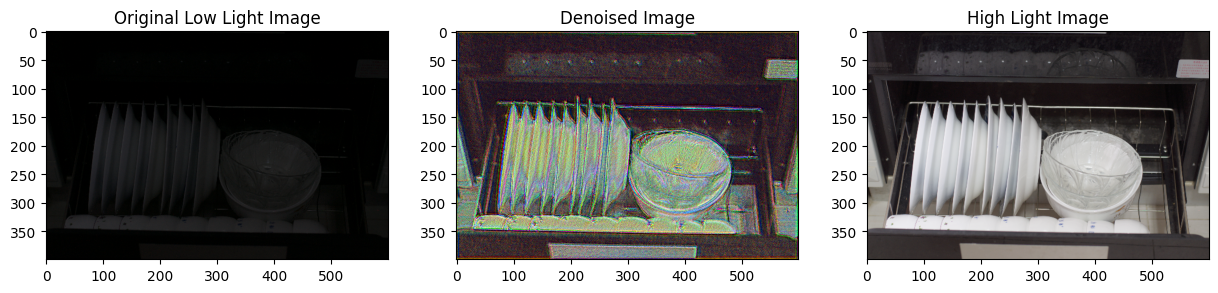

In [ ]:
# Display the original, denoised, and high light images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Low Light Image')
plt.imshow(test_low_light_image)
plt.subplot(1, 3, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.subplot(1, 3, 3)
plt.title('High Light Image')
plt.imshow(test_high_light_image)
plt.show()



In [ ]:
# Calculate PSNR
psnr_value = psnr(test_high_light_image, denoised_image)
print(f"PSNR: {psnr_value} dB")

PSNR: 14.095759657585184 dB


<ipython-input-25-63935fc1472e>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(test_high_light_image, denoised_image)


In [ ]:
#optimising code  , Iteration 2

In [ ]:
# Helper function to read and preprocess images
def read_images(image_paths):
    images = []
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_COLOR)  # Adjust based on your image format requirements
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if necessary
        # Resize image to (256, 256) to match model input shape
        image = cv2.resize(image, (256, 256))
        # Normalize pixel values to range [0, 1]
        image = image.astype('float32') / 255.0
        images.append(image)
    return np.array(images)

In [ ]:
# Load low light and high light images
low_light_image_paths = sorted([os.path.join(train_low_path, img) for img in os.listdir(train_low_path) if is_image_file(img)])
high_light_image_paths = sorted([os.path.join(train_high_path, img) for img in os.listdir(train_high_path) if is_image_file(img)])

low_light_images = read_images(low_light_image_paths)
high_light_images = read_images(high_light_image_paths)

In [ ]:
# Define residual block function
def residual_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    res = Conv2D(filters, kernel_size, padding=padding)(x)
    res = BatchNormalization()(res)
    res = Activation(activation)(res)
    res = Conv2D(filters, kernel_size, padding=padding)(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])
    return x


# Build denoising model
def build_denoising_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding more residual blocks
    for _ in range(12):  # Increase the depth of the network
        x = residual_block(x, 64)

    outputs = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
# Build the denoising model
input_shape = low_light_images[0].shape
model = build_denoising_model(input_shape)
model.summary()

# Define loss function and optimizer
loss_function = MeanSquaredError()

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Training parameters
epochs = 100
batch_size = 32
accumulation_steps = 4

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [ ]:
# Data generator function
def data_generator(low_light_images, high_light_images, batch_size):
    while True:
        indices = np.random.choice(len(low_light_images), batch_size, replace=False)
        low_batch = low_light_images[indices]
        high_batch = high_light_images[indices]
        yield low_batch, high_batch

In [ ]:
# Training loop
@tf.function
def train_step(low_light_batch, high_light_batch):
    with tf.GradientTape() as tape:
        predictions = model(low_light_batch, training=True)
        loss = loss_function(high_light_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients


In [ ]:
# Initialize variables for gradient accumulation
accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
accumulated_loss = tf.Variable(0.0, trainable=False)

# Initialize time tracking variables
start_time = time.time()
time_per_step = 0.0

# Training loop
for epoch in range(1, epochs + 1):
    gen = data_generator(low_light_images, high_light_images, batch_size // accumulation_steps)

    for step in range(len(low_light_images) // batch_size):
        current_step = epoch * (len(low_light_images) // batch_size) + step

        low_light_batch, high_light_batch = next(gen)
        loss, gradients = train_step(low_light_batch, high_light_batch)
        accumulated_loss.assign_add(loss / accumulation_steps)

        # Accumulate gradients
        for i, grad in enumerate(gradients):
            accumulated_gradients[i].assign_add(grad / accumulation_steps)

        # Apply gradients
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
            # Reset accumulated gradients and loss
            for var in accumulated_gradients:
                var.assign(tf.zeros_like(var))
            accumulated_loss.assign(0.0)

        # Calculate time per step
        end_time = time.time()
        time_per_step = (end_time - start_time) / (current_step + 1)  # Average time per step

        # Estimate remaining time
        steps_left = (epochs - epoch) * (len(low_light_images) // batch_size) + (len(low_light_images) // batch_size - step)
        time_remaining = steps_left * time_per_step

        # Print progress
        print(f"Epoch {epoch}/{epochs} - Step {step+1}/{len(low_light_images) // batch_size} - "
              f"Time per step: {time_per_step:.2f} s - "
              f"Time remaining: {time_remaining:.2f} s")

    # Reset start time for the next epoch
    start_time = time.time()

print("Training completed.")

Epoch 1/100 - Step 1/15 - Time per step: 0.40 s - Time remaining: 603.16 s
Epoch 1/100 - Step 2/15 - Time per step: 0.38 s - Time remaining: 570.64 s
Epoch 1/100 - Step 3/15 - Time per step: 0.41 s - Time remaining: 607.46 s


Epoch 1/100 - Step 4/15 - Time per step: 1.02 s - Time remaining: 1529.40 s
Epoch 1/100 - Step 5/15 - Time per step: 0.97 s - Time remaining: 1455.36 s
Epoch 1/100 - Step 6/15 - Time per step: 0.97 s - Time remaining: 1451.49 s
Epoch 1/100 - Step 7/15 - Time per step: 0.96 s - Time remaining: 1441.08 s
Epoch 1/100 - Step 8/15 - Time per step: 0.99 s - Time remaining: 1471.60 s
Epoch 1/100 - Step 9/15 - Time per step: 0.95 s - Time remaining: 1423.66 s
Epoch 1/100 - Step 10/15 - Time per step: 0.95 s - Time remaining: 1415.67 s
Epoch 1/100 - Step 11/15 - Time per step: 0.95 s - Time remaining: 1408.60 s
Epoch 1/100 - Step 12/15 - Time per step: 0.95 s - Time remaining: 1417.01 s
Epoch 1/100 - Step 13/15 - Time per step: 0.94 s - Time remaining: 1396.37 s
Epoch 1/100 - Step 14/15 - Time per step: 0.94 s - Time remaining: 1390.54 s
Epoch 1/100 - Step 15/15 - Time per step: 0.93 s - Time remaining: 1385.34 s
Epoch 2/100 - Step 1/15 - Time per step: 0.03 s - Time remaining: 40.93 s
Epoch 2/

1/1 [==============================] - 0s 20ms/step


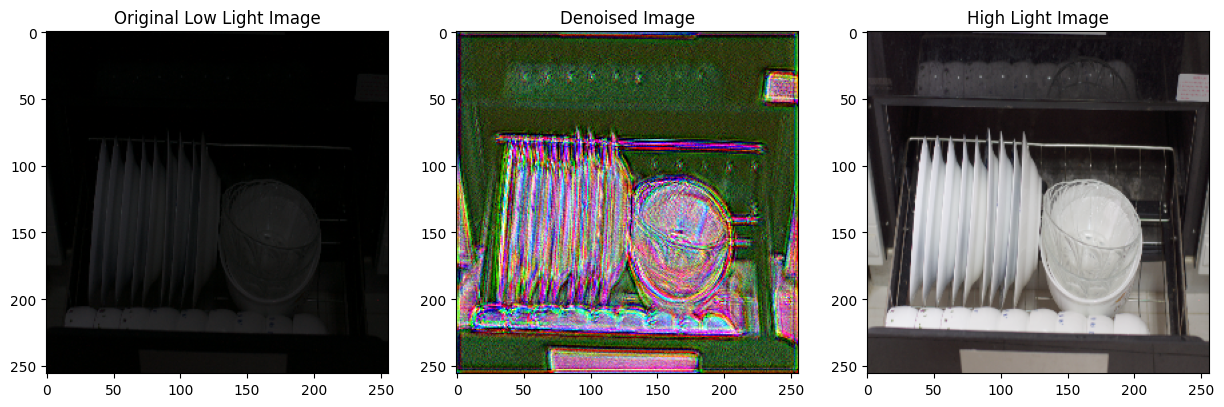

PSNR: 11.843011935258144 dB


In [ ]:
# Evaluate the model on a test image
test_low_light_image = cv2.resize(load_image(low_light_images[1]), (256, 256))  # Load and resize the low light test image
test_high_light_image = cv2.resize(load_image(high_light_images[1]), (256, 256))  # Load and resize the high light test image

# Predict on the denoised image
denoised_image = model.predict(np.expand_dims(test_low_light_image, axis=0))[0]

# Ensure all images have correct shapes for visualization
test_low_light_image = cv2.resize(test_low_light_image, (256, 256))  # Resize to (256, 256) for visualization
test_high_light_image = cv2.resize(test_high_light_image, (256, 256))  # Resize to (256, 256) for visualization
denoised_image = cv2.resize(denoised_image, (256, 256))  # Resize to (256, 256) for visualization

# Display original low light, denoised, and high light images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Low Light Image')
plt.imshow(test_low_light_image)
plt.subplot(1, 3, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.subplot(1, 3, 3)
plt.title('High Light Image')
plt.imshow(test_high_light_image)
plt.show()

# Calculate PSNR between high light image and denoised image
psnr_value = psnr(test_high_light_image, denoised_image)
print(f"PSNR: {psnr_value} dB")


In [ ]:
# Doing iteration for the third time with changed parameters


In [ ]:
def residual_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    res = Conv2D(filters, kernel_size, padding=padding)(x)
    res = BatchNormalization()(res)
    res = Activation(activation)(res)
    res = Conv2D(filters, kernel_size, padding=padding)(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])
    return x

In [ ]:
def build_denoising_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding more residual blocks
    for _ in range(2):  # Increase the depth of the network
        x = residual_block(x, 64)

    outputs = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = low_light_image.shape
model = build_denoising_model(input_shape)
model.summary()

# Define loss function and optimizer
loss_function = MeanSquaredError()

# Learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# Training parameters
epochs = 60
batch_size = 32
accumulation_steps = 3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 600, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 400, 600, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 400, 600, 64)         0         ['batch_normalization[0][0

In [ ]:
# Prepare the data generator
def data_generator(low_light_images, high_light_images, batch_size):
    while True:
        indices = np.random.choice(len(low_light_images), batch_size, replace=False)
        low_batch = np.array([load_image(low_light_images[i]) for i in indices])
        high_batch = np.array([load_image(high_light_images[i]) for i in indices])
        yield low_batch, high_batch

# Training loop with gradient accumulation
@tf.function
def train_step(low_light_batch, high_light_batch):
    with tf.GradientTape() as tape:
        predictions = model(low_light_batch, training=True)
        loss = loss_function(high_light_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

In [ ]:
import time

# Initialize variables for gradient accumulation
accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
accumulated_loss = tf.Variable(0.0, trainable=False)

# Initialize time tracking variables
start_time = time.time()
time_per_step = 0.0

for epoch in range(1, epochs + 1):
    gen = data_generator(low_light_images, high_light_images, batch_size // accumulation_steps)

    for step in range(len(low_light_images) // batch_size):
        current_step = epoch * (len(low_light_images) // batch_size) + step

        low_light_batch, high_light_batch = next(gen)
        loss, gradients = train_step(low_light_batch, high_light_batch)
        accumulated_loss.assign_add(loss / accumulation_steps)

        # Accumulate gradients
        for i, grad in enumerate(gradients):
            accumulated_gradients[i].assign_add(grad / accumulation_steps)

        # Apply gradients
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
            # Reset accumulated gradients and loss
            for var in accumulated_gradients:
                var.assign(tf.zeros_like(var))
            accumulated_loss.assign(0.0)

        # Calculate time per step
        end_time = time.time()
        time_per_step = (end_time - start_time) / (current_step + 1)  # Average time per step

        # Estimate remaining time
        steps_left = (epochs - epoch) * (len(low_light_images) // batch_size) + (len(low_light_images) // batch_size - step)
        time_remaining = steps_left * time_per_step

        # Print progress
        print(f"Epoch {epoch}/{epochs} - Step {step+1}/{len(low_light_images) // batch_size} - "
              f"Time per step: {time_per_step:.2f} s - "
              f"Time remaining: {time_remaining:.2f} s")

    # Reset start time for the next epoch
    start_time = time.time()

print("Training completed.")



Epoch 1/60 - Step 1/15 - Time per step: 0.34 s - Time remaining: 302.51 s
Epoch 1/60 - Step 2/15 - Time per step: 0.57 s - Time remaining: 516.32 s
Epoch 1/60 - Step 3/15 - Time per step: 0.84 s - Time remaining: 756.36 s
Epoch 1/60 - Step 4/15 - Time per step: 1.01 s - Time remaining: 908.57 s
Epoch 1/60 - Step 5/15 - Time per step: 1.18 s - Time remaining: 1053.38 s
Epoch 1/60 - Step 6/15 - Time per step: 1.34 s - Time remaining: 1202.35 s
Epoch 1/60 - Step 7/15 - Time per step: 1.50 s - Time remaining: 1337.00 s
Epoch 1/60 - Step 8/15 - Time per step: 1.64 s - Time remaining: 1460.80 s
Epoch 1/60 - Step 9/15 - Time per step: 1.74 s - Time remaining: 1553.68 s
Epoch 1/60 - Step 10/15 - Time per step: 1.86 s - Time remaining: 1661.18 s
Epoch 1/60 - Step 11/15 - Time per step: 1.97 s - Time remaining: 1753.39 s
Epoch 1/60 - Step 12/15 - Time per step: 1.98 s - Time remaining: 1762.27 s
Epoch 1/60 - Step 13/15 - Time per step: 1.99 s - Time remaining: 1769.78 s
Epoch 1/60 - Step 14/15 -

In [ ]:
# Evaluate the model on a test image
test_low_light_image = load_image(low_light_images[1])  # Replace with an actual test image
test_high_light_image = load_image(high_light_images[1])  # Replace with an actual test image

denoised_image = model.predict(np.expand_dims(test_low_light_image, axis=0))[0]

1/1 [==============================] - 1s 783ms/step


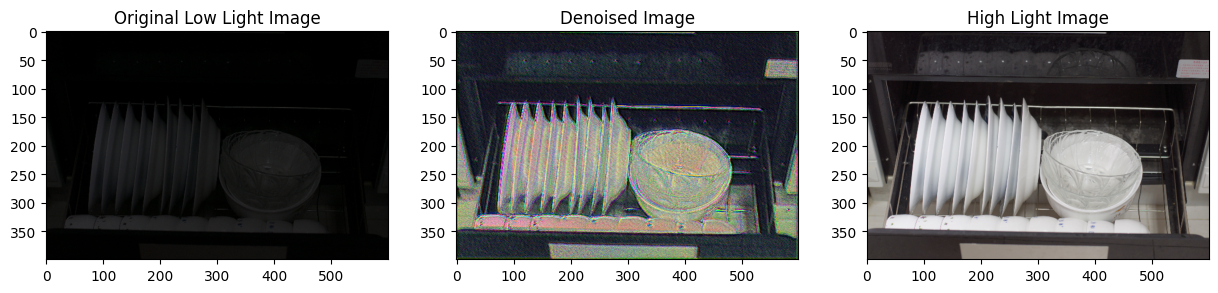

In [ ]:
# Display the original, denoised, and high light images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Low Light Image')
plt.imshow(test_low_light_image)
plt.subplot(1, 3, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.subplot(1, 3, 3)
plt.title('High Light Image')
plt.imshow(test_high_light_image)
plt.show()



In [ ]:
# Calculate PSNR between high light image and denoised image
psnr_value = psnr(test_high_light_image, denoised_image)
print(f"PSNR: {psnr_value} dB")

PSNR: 15.365831036934587 dB


<ipython-input-14-93759ef0eed6>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(test_high_light_image, denoised_image)


In [ ]:
# trying the last iteration  with more changed parameters

In [8]:
def residual_block(x, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    res = Conv2D(filters, kernel_size, padding=padding)(x)
    res = BatchNormalization()(res)
    res = Activation(activation)(res)
    res = Conv2D(filters, kernel_size, padding=padding)(res)
    res = BatchNormalization()(res)
    x = Add()([x, res])
    return x

def build_denoising_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding more residual blocks
    for _ in range(3):  # Increase the depth of the network
        x = residual_block(x, 64)

    outputs = Conv2D(3, (3, 3), padding='same')(x)
    model = Model(inputs, outputs)
    return model

In [9]:
input_shape = low_light_image.shape
model = build_denoising_model(input_shape)
model.summary()

# Define loss function and optimizer
loss_function = MeanSquaredError()

# Learning rate scheduler
lr_schedule = ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# Training parameters
epochs = 30
batch_size = 16
accumulation_steps = 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 600, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 400, 600, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 400, 600, 64)         0         ['batch_normalization[0][0

In [10]:
# Prepare the data generator
def data_generator(low_light_images, high_light_images, batch_size):
    while True:
        indices = np.random.choice(len(low_light_images), batch_size, replace=False)
        low_batch = np.array([load_image(low_light_images[i]) for i in indices])
        high_batch = np.array([load_image(high_light_images[i]) for i in indices])
        yield low_batch, high_batch

# Training loop with gradient accumulation
@tf.function
def train_step(low_light_batch, high_light_batch):
    with tf.GradientTape() as tape:
        predictions = model(low_light_batch, training=True)
        loss = loss_function(high_light_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

In [11]:
import time

# Initialize variables for gradient accumulation
accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
accumulated_loss = tf.Variable(0.0, trainable=False)

# Initialize time tracking variables
start_time = time.time()
time_per_step = 0.0

for epoch in range(1, epochs + 1):
    gen = data_generator(low_light_images, high_light_images, batch_size // accumulation_steps)

    for step in range(len(low_light_images) // batch_size):
        current_step = epoch * (len(low_light_images) // batch_size) + step

        low_light_batch, high_light_batch = next(gen)
        loss, gradients = train_step(low_light_batch, high_light_batch)
        accumulated_loss.assign_add(loss / accumulation_steps)

        # Accumulate gradients
        for i, grad in enumerate(gradients):
            accumulated_gradients[i].assign_add(grad / accumulation_steps)

        # Apply gradients
        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
            # Reset accumulated gradients and loss
            for var in accumulated_gradients:
                var.assign(tf.zeros_like(var))
            accumulated_loss.assign(0.0)

        # Calculate time per step
        end_time = time.time()
        time_per_step = (end_time - start_time) / (current_step + 1)  # Average time per step

        # Estimate remaining time
        steps_left = (epochs - epoch) * (len(low_light_images) // batch_size) + (len(low_light_images) // batch_size - step)
        time_remaining = steps_left * time_per_step

        # Print progress
        print(f"Epoch {epoch}/{epochs} - Step {step+1}/{len(low_light_images) // batch_size} - "
              f"Time per step: {time_per_step:.2f} s - "
              f"Time remaining: {time_remaining:.2f} s")

    # Reset start time for the next epoch
    start_time = time.time()

print("Training completed.")



Epoch 1/30 - Step 1/30 - Time per step: 0.79 s - Time remaining: 707.02 s


Epoch 1/30 - Step 2/30 - Time per step: 1.06 s - Time remaining: 950.44 s
Epoch 1/30 - Step 3/30 - Time per step: 1.21 s - Time remaining: 1084.55 s
Epoch 1/30 - Step 4/30 - Time per step: 1.32 s - Time remaining: 1184.30 s
Epoch 1/30 - Step 5/30 - Time per step: 1.49 s - Time remaining: 1339.47 s
Epoch 1/30 - Step 6/30 - Time per step: 1.61 s - Time remaining: 1439.60 s
Epoch 1/30 - Step 7/30 - Time per step: 1.72 s - Time remaining: 1534.99 s
Epoch 1/30 - Step 8/30 - Time per step: 1.85 s - Time remaining: 1651.32 s
Epoch 1/30 - Step 9/30 - Time per step: 1.91 s - Time remaining: 1699.40 s
Epoch 1/30 - Step 10/30 - Time per step: 1.99 s - Time remaining: 1773.60 s
Epoch 1/30 - Step 11/30 - Time per step: 2.04 s - Time remaining: 1817.62 s
Epoch 1/30 - Step 12/30 - Time per step: 2.11 s - Time remaining: 1880.03 s
Epoch 1/30 - Step 13/30 - Time per step: 2.15 s - Time remaining: 1904.93 s
Epoch 1/30 - Step 14/30 - Time per step: 2.23 s - Time remaining: 1975.78 s
Epoch 1/30 - Step 15/

1/1 [==============================] - 1s 813ms/step


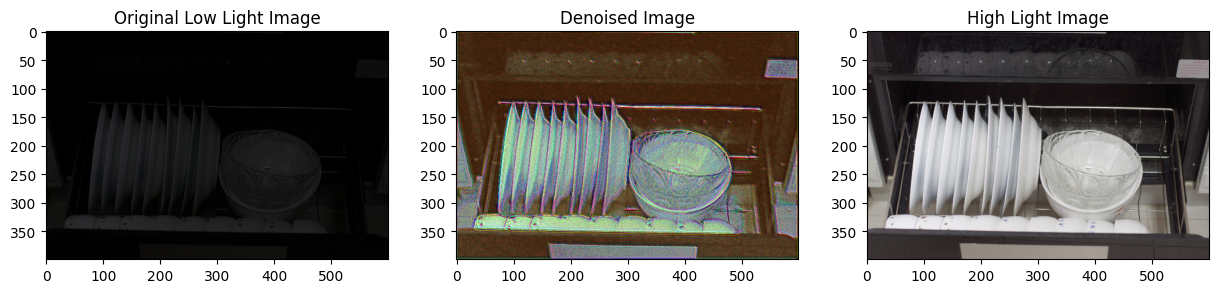

In [12]:
# Evaluate the model on a test image
test_low_light_image = load_image(low_light_images[1])  # Replace with an actual test image
test_high_light_image = load_image(high_light_images[1])  # Replace with an actual test image

denoised_image = model.predict(np.expand_dims(test_low_light_image, axis=0))[0]

# Display the original, denoised, and high light images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Low Light Image')
plt.imshow(test_low_light_image)
plt.subplot(1, 3, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image)
plt.subplot(1, 3, 3)
plt.title('High Light Image')
plt.imshow(test_high_light_image)
plt.show()



In [13]:
# Calculate PSNR between high light image and denoised image
psnr_value = psnr(test_high_light_image, denoised_image)
print(f"PSNR: {psnr_value} dB")

PSNR: 15.618873052452994 dB


<ipython-input-13-93759ef0eed6>:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(test_high_light_image, denoised_image)
